Network optimization
===

***
# <span style="color:brown"> Preamble

This notbook illustrates the use of neural network as an optimizer tool without the notion of training. This notebook allows to focus on the design of neural networks through pytorch wihtout using the learning paradigm
    
# <span style="color:brown"> Objectives

* Consolidate the knowledge on neural network.
* Develop a MLP in pytorch that will be used as a kernel interpolator to perform interpolation of approximation tasks
* Train your own U-Net (part 2 of this hands-on).
    
***
    

# <span style="color:brown"> Physical problem: modeling of temperature decay over time

The toy example used in this notebook concerns the estimation of the value of the temperature decay over time from a set of measured point. The physical equation that we are going to use is based on the Newton's law of cooling:
        
\begin{equation}
  \left\{
    \begin{aligned}
      &T(t) = T_{env} + \left( T_0 - T_{env} \right) \cdot e^{-kt} \\
      &\frac{d T}{d t} = k \left( T_{env}-T \right)
    \end{aligned}
  \right.
\end{equation}
    
    
where

- $T(t)$ represents the temperature of a system at a given time. It is a function of time.
- $T_{env}$ represents the ambient temperature of the environment surrounding the system. It is assumed to be constant.
- $T_{0}$ represents the initial temperature of the system at time t = 0. It is also assumed to be constant.
- $k$ is a decay constant that determines the rate of temperature decay over time. It is also assumed to be constant.
- $t$ represents the time variable in the equation. It represents the elapsed time since the initial temperature measurement.   
   
<br>
    
Here is an illustration of the behavior of the cooling law:
    
<img src="figures/illustration_cooling_law.png" alt="cooling_law" style="width: 70%;"/>
    
    
***

# <span style="color:brown"> Before starting: system setting
 
### <span style="color:red"> Instruction: </span> Run the cell below to import all the packages that you will need during this session.

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
    
- [torch](https://pytorch.org/) is a python geometric library for deep learning on irregular input data such as graphs, point clouds, and manifolds.
    
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

- [functools](https://docs.python.org/3/library/functools.html#) is a python module to manage higher-order functions and operations on callable objects. Higher-order functions are functions that act on or return other functions. In general, any callable object can be treated as a function for the purposes of this module.
    

In [12]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

<br>
We put the following command lines to:

- automatically work on either CPU or GPU, depending on the hardward that is currently used
- fix the random process to have reproducible results

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

***

# <span style="color:brown"> 1) Setting up the cooling problem and prepare the input data

In this part of the session, you will:

- Define the main variables of the cooling law
- Compute the equation of the cooling law for a set of predifined temperature values
- Define fake experimental measurements of the temperature with some randomness 

### <span style="color:red"> Instruction: </span> Run the cell below to generate the different inputs.

In [14]:
def cooling_law(time, Tenv, T0, k):
    T = Tenv + (T0 - Tenv) * np.exp(-k * time)
    return T

Text(0.5, 0, 'Time (s)')

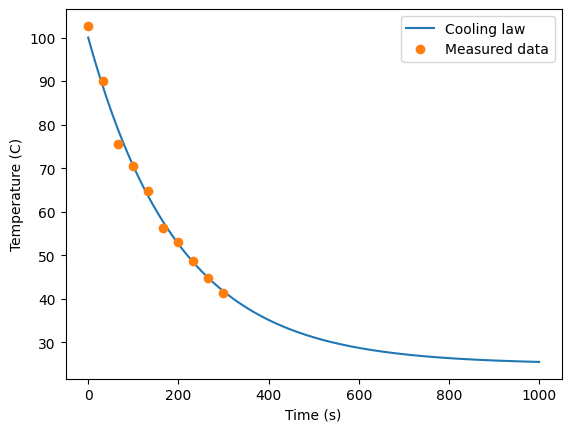

In [39]:
# Force randomness to generate the same values for reproducibility
np.random.seed(10)

# Define the cooling parameters
Tenv = 25   # Ambiant temperature
T0 = 100    # Starting temperature
k = 0.005   # Decay constant

# Define the full time axis of interest 
times = np.linspace(0, 1000, 1000)

# Define the corresponding cooling law 
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, k=k)

# Compute temperature values based on the pre-defined cooling law
temperatures = eq(times)

# Make measured data points with randomness
time_samples = np.linspace(0, 300, 10)
temperature_samples = eq(t) +  2 * np.random.randn(10)

# Display the generated input that caracterize the problem
plt.plot(times, temperature_ref)
plt.plot(time_samples, temperature_samples, 'o')
plt.legend(['Cooling law', 'Measured data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

***

# <span style="color:brown"> 2) Exploit a standard neural network as optimization tool
    
As presented in the introduction of this hands-on session, you will develop a Neural Network (NN) as an optimization tool. The NN will consist of a multilayer perceptron (MLP) whose optimisation will allow the fitting of experimental measurements.

## <span style="color:brown"> 1.1) Create a standard neural network
    
### <span style="color:red"> Instruction: </span> Run the cell below to create a neural network with a MLP architecture.
    
**Remark:** The MLP is composed of 5 layers followed by ReLU activations

In [65]:
# Definition of the neural network class
class Net(nn.Module):
    
    # Define the constructor class with inheritance
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__() 

        # Define attributs
        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        # Define key layers which combined represents the 
        # architecture of the network.
        # In our case, it corresponds to a MLP with 5 layers 
        # (1x100x100x100x100x1)
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    # Define a function to go from numpy to torch structure 
    # which will work on the selected DEVICE (cpu or gpu)
    def np_to_th(self, x):
        n_samples = len(x)
        return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)        
        
    # Define the forward pass operations
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out

    # Define the optimization procedure 
    def optimize(self, X, y):
        # Convert numpy to torch structure
        Xt = self.np_to_th(X)
        yt = self.np_to_th(y)
        # Define the method used during optimization
        # optim.Adam is an optimizer define in pytorch
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        # TODO
        self.train()
        losses = []
        # Main iteration loop to optimize the MLP parmameters
        for ep in range(self.epochs):
            # At each iteration we need to set the computed gradient to zero
            # since the call to the backward function will automatically compute
            # the NN gradients
            optimiser.zero_grad()
            # Apply the forward pass
            outputs = self.forward(Xt)
            # Compute the corresponding loss value based on the predicted outputs
            loss = self.loss(yt, outputs)
            # Update the loss value if an additional loss is defined
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
                # loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            # Compute the backward pass
            # This step will compute the NN gradient thank to autograd concepts
            loss.backward()
            # Update the NN parameters based on the NN gradient previously comuted
            # and the optimizer scheme (in this example adam)
            optimiser.step()
            # Store the value of the loss function
            losses.append(loss.item())
            # Display loss value each round(self.epochs/10) epochs 
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        # Return the losses list at the end of the main loop
        return losses

    # Define predict function.
    # This function will be called after the network have been trained
    def predict(self, X):
        # TODO
        self.eval()
        # Apply the forward pass
        out = self.forward(self.np_to_th(X))
        # Return a self-sufficient numpy structure without any link with the NN
        return out.detach().cpu().numpy()


## <span style="color:brown"> 1.2) Optimize the NN to fit the measured data 
    
### <span style="color:red"> Instruction: </span> Run the cell below to optimize the NN so that its output fit the measure data.
    
**Remark:** The fit is provided by minimizing the loss function at each epoch, by default the mean square error (i.e., nn.MSELoss)

Epoch 0/20000, loss: 4657.17
Epoch 2000/20000, loss: 2458.14
Epoch 4000/20000, loss: 1677.66
Epoch 6000/20000, loss: 120.75
Epoch 8000/20000, loss: 1.33
Epoch 10000/20000, loss: 1.05
Epoch 12000/20000, loss: 0.98
Epoch 14000/20000, loss: 0.83
Epoch 16000/20000, loss: 0.63
Epoch 18000/20000, loss: 0.47


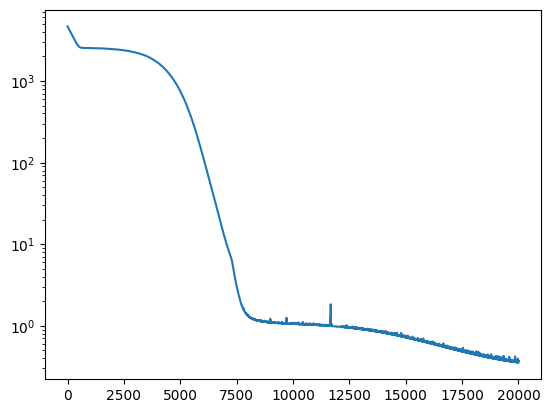

In [66]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardward system on 
# which the NN have to be optimized
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

# Optimize the NN
losses = net.optimize(time_samples, temperature_samples)

# Display the evolution of the loss over the epoch 
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale('log')

## <span style="color:brown"> 1.3) Run the NN after the optimization procedure to predict the temperature values at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperature at the full range time vector (outside the measured temperature to check the predictive value of the NN).

Text(0.5, 0, 'Time (s)')

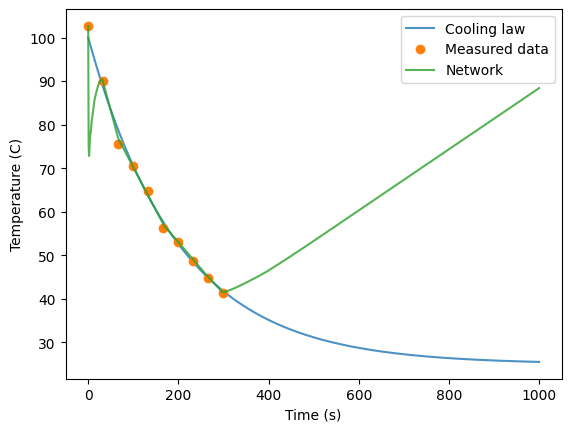

In [67]:
# Make the NN predicts the temperature values from the full range time axis
temperature_predictions = net.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, 'o')
plt.plot(times, temperature_predictions, alpha=0.8)
plt.legend(labels=['Cooling law','Measured data', 'Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## <span style="color:brown"> 2.1) Constrain the standard neural network behavior with a regularization loss
    
### <span style="color:red"> Instruction: </span> Run the cell below to create an additional loss to constrain the value of the neural network to impose som regularization on the prediction output.
    
**Remark:** The additional loss corresponds to the $L_2$ norm, i.e. $L_2=||\theta\||^2$ which forces the NN values to be as small as possible

In [68]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

## <span style="color:brown"> 2.2) Optimize the $L_2$ NN to fit the measured data 
    
### <span style="color:red"> Instruction: </span> Run the cell below to optimize the NN so that its output fit the measure data.
    
**Remark:** The fit is provided by minimizing the two loss functions at each epoch, i.e., nn.MSELoss + loss2_weight*loss2

Epoch 0/30000, loss: 11294.31
Epoch 3000/30000, loss: 3033.00
Epoch 6000/30000, loss: 1601.90
Epoch 9000/30000, loss: 1080.04
Epoch 12000/30000, loss: 924.03
Epoch 15000/30000, loss: 834.17
Epoch 18000/30000, loss: 746.05
Epoch 21000/30000, loss: 664.13
Epoch 24000/30000, loss: 581.08
Epoch 27000/30000, loss: 508.86


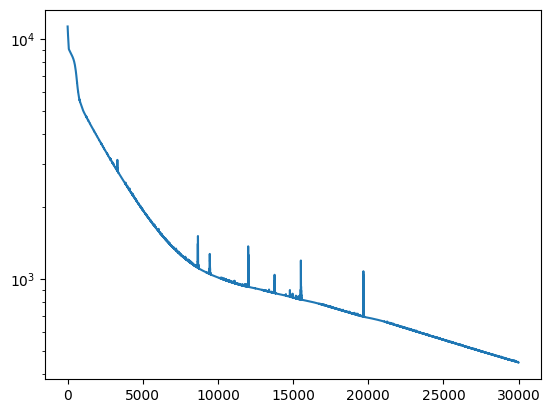

In [69]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardward system on 
# which the NN have to be optimized
L2net = Net(1,1, loss2=l2_reg, loss2_weight=1, epochs=30000, lr=1e-4).to(DEVICE)

# Optimize the NN
losses = L2net.optimize(t, T)

# Display the evolution of the loss over the epoch 
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale('log')

## <span style="color:brown"> 2.3) Run the $L_2$ NN after the optimization procedure to predict the temperature values at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperature at the full range time vector (outside the measured temperature to check the predictive value of the NN).

Text(0.5, 0, 'Time (s)')

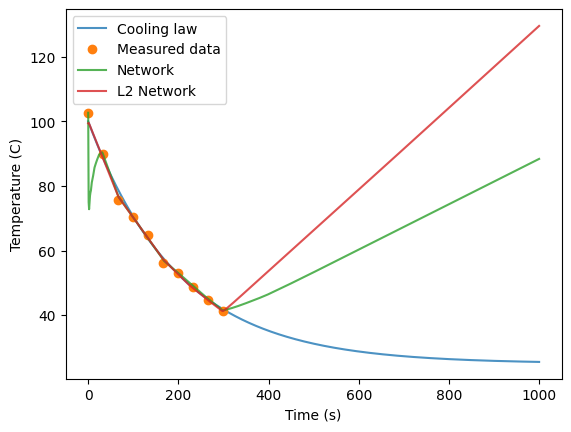

In [70]:
# Make the L2 NN predicts the temperature values from the full range time axis
temperature_predictions_L2 = L2net.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, 'o')
plt.plot(times, temperature_predictions, alpha=0.8)
plt.plot(times, temperature_predictions_L2, alpha=0.8)
plt.legend(labels=['Cooling law','Measured data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

***

# <span style="color:brown"> 3) Exploit the Physics Informed Neural Network (PINN) paradigm to perform optimization
    
We will now solve the optimization problem through the paradigm of physics informed neural network. The key idea is to compute the gradient of the outputs of the NN to compute an additional physical loss based on the respect of the cooling law !
    
<br>
    
Here is an illustration of the general scheme of PINN:
    
<img src="figures/illustration_pinn.png" alt="cooling_law" style="width: 100%;"/>

## <span style="color:brown"> 3.1) Constrain the standard neural network behavior with a physics-informed loss
    
### <span style="color:red"> Instruction: </span> Run the cell below to create an additional loss to constrain the value of the neural network to impose physical regularization on the prediction output.
    
**Remark:** The additional loss corresponds to the residual of physical equation

In [59]:
# Define the gradient function that will be applied to the output of the NN
def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

In [71]:
def physics_loss(model: torch.nn.Module):
    # Define the full time axis of interest 
    times_full = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    # Compute the corresponding estimated temperature
    temperatures_full = model(times_full)
    # Compute the corresponding gradients
    dT = grad(temperatures_full, times_full)[0]
    # Compute residual loss for each temperature term 
    residual = dT - k * (Tenv - temperatures_full)
    # Return residual loss 
    return torch.mean(residual**2)

## <span style="color:brown"> 3.2) Optimize the PINN to fit the measured data 
    
### <span style="color:red"> Instruction: </span> Run the cell below to optimize the PINN so that its output fit the measure data.
    
**Remark:** The fit is provided by minimizing the two loss functions at each epoch, i.e., nn.MSELoss + physics_loss_weight * physics_loss

Epoch 0/20000, loss: 4554.62
Epoch 2000/20000, loss: 2526.38
Epoch 4000/20000, loss: 2228.81
Epoch 6000/20000, loss: 902.96
Epoch 8000/20000, loss: 7.47
Epoch 10000/20000, loss: 0.88
Epoch 12000/20000, loss: 0.78
Epoch 14000/20000, loss: 0.63
Epoch 16000/20000, loss: 0.51
Epoch 18000/20000, loss: 0.43


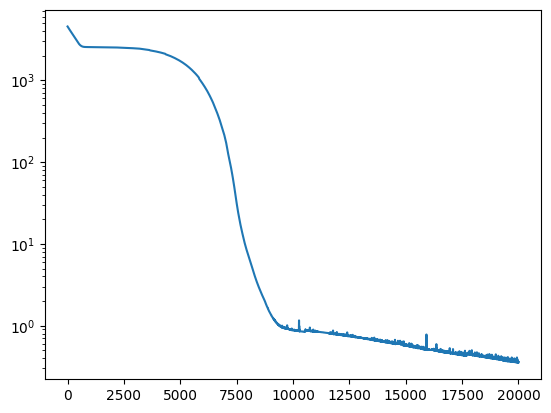

In [78]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardward system on 
# which the PINN have to be optimized
pinn_net = Net(1,1, loss2=physics_loss, loss2_weight=1, epochs=20000, lr=1e-5).to(DEVICE)

# Optimize the PINN
losses = pinn_net.optimize(t, T)

# Display the evolution of the loss over the epoch 
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale('log')

## <span style="color:brown"> 3.3) Run the PINN after the optimization procedure to predict the temperature values at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperature at the full range time vector (outside the measured temperature to check the predictive value of the NN).

Text(0.5, 0, 'Time (s)')

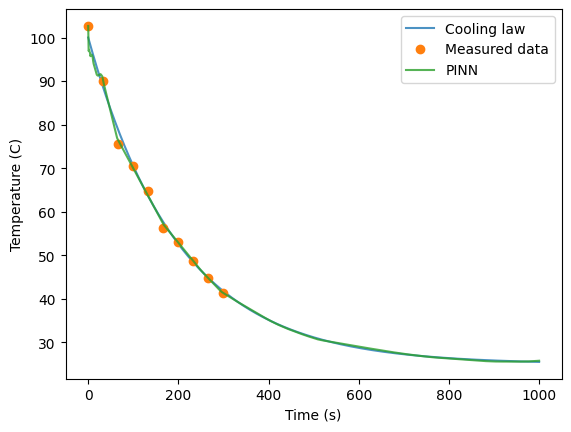

In [79]:
# Make the PINN predicts the temperature values from the full range time axis
temperature_predictions_pinn = pinn_net.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, 'o')
plt.plot(times, temperature_predictions_pinn, alpha=0.8)
plt.legend(labels=['Cooling law','Measured data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## <span style="color:brown"> 3.4) Add the estimation of the optimal decay value during the optimization preocedure using PINN paradigm
    
### <span style="color:red"> Instruction: </span> Run the cell below to create an additional loss to constrain the value of the neural network to impose physical regularization on the prediction output along with the prediction of the decay value.
    
**Remark:** The additional loss corresponds to the residual of physical equation

In [84]:
def physics_loss_discovery(model: torch.nn.Module):
    # Define the full time axis of interest 
    times_full = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    # Compute the corresponding estimated temperature
    temperatures_full = model(times_full)
    # Compute the corresponding gradients
    dT = grad(temperatures_full, times_full)[0]
    # Compute residual loss for each temperature term 
    residual = dT - model.k * (Tenv - temperatures_full)
    # Return residual loss 
    return torch.mean(residual**2)

## <span style="color:brown"> 3.5) Optimize the PINN to fit the measured data 
    
### <span style="color:red"> Instruction: </span> Run the cell below to optimize the PINN so that its output fit the measure data.
    
**Remark:** The fit is provided by minimizing the two loss functions at each epoch, i.e., nn.MSELoss + physics_loss_discovery_weight * physics_loss_discovery

In [85]:
# Definition of the neural network class
class NetDiscovery(Net):
    # Define the constructor class with Net inheritance 
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        # Define new attribute
        self.k = nn.Parameter(data=torch.tensor([0.]))

Epoch 0/40000, loss: 4548.72
Epoch 4000/40000, loss: 2526.17
Epoch 8000/40000, loss: 2297.18
Epoch 12000/40000, loss: 767.77
Epoch 16000/40000, loss: 6.35
Epoch 20000/40000, loss: 1.86
Epoch 24000/40000, loss: 1.30
Epoch 28000/40000, loss: 0.61
Epoch 32000/40000, loss: 0.39
Epoch 36000/40000, loss: 0.34


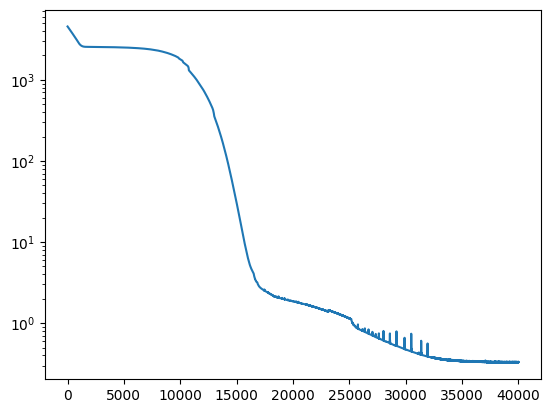

In [86]:
# Instantiate a network object from the Net class
# The ".to(DEVICE)" specifies the hardward system on 
# which the PINN have to be optimized
pinn_netdisc = NetDiscovery(1,1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr=5e-6).to(DEVICE)

# Optimize the PINN
losses = pinn_netdisc.optimize(t, T)

# Display the evolution of the loss over the epoch 
# to check the good behavior of this phase, i.e., the loss must decrease
plt.plot(losses)
plt.yscale('log')

## <span style="color:brown"> 3.6) Run the PINN after the optimization procedure to predict the temperature values at the full range time vector
    
### <span style="color:red"> Instruction: </span> Run the cell below to predict the temperature at the full range time vector (outside the measured temperature to check the predictive value of the NN).



Decay value used in the cooling law function = 0.005
Estimated decay value = [0.0050336] 



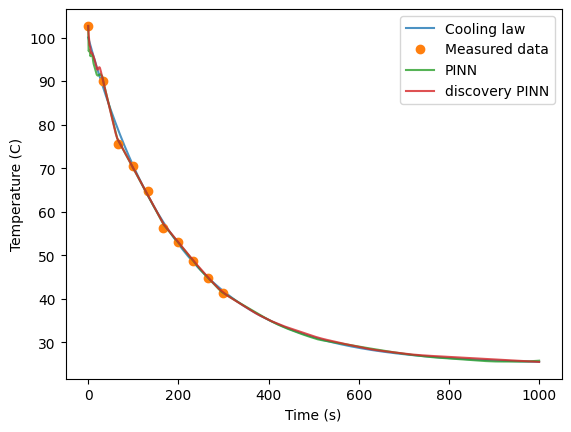

In [100]:
# Make the PINN predicts the temperature values from the full range time axis
temperature_predictions_pinn_disc = pinn_netdisc.predict(times)

# Display the predicted results
plt.plot(times, temperatures, alpha=0.8)
plt.plot(time_samples, temperature_samples, 'o')
plt.plot(times, temperature_predictions_pinn, alpha=0.8)
plt.plot(times, temperature_predictions_pinn_disc, alpha=0.8)
plt.legend(labels=['Cooling law','Measured data', 'PINN', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

print("\n")
print(f"Decay value used in the cooling law function = {k}")
print(f"Estimated decay value = {pinn_netdisc.k.detach().numpy()} \n")